# Stable Diffusion

\
Stable Diffusion is a machine learning, text-to-image model developed by StabilityAI, in collaboration with EleutherAI and LAION, to generate digital images from natural language descriptions.

\
It can run on most consumer hardware equipped with a modest GPU and was hailed by PC World as "the next killer app for your PC".

\
Unlike models like DALL-E, Stable Diffusion makes its source code available. Its license prohibits certain harmful use cases. One can use Stable Diffusion online via the [Huggingface interface](https://huggingface.co/spaces/stabilityai/stable-diffusion).

\
This tutorial shows how to use Stable Diffusion with the Hugging Face through Google Colab.

\
References and further readings:
* [Stable Diffusion Google Colab Implementation](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)
* [Wikipedia Introduction to Stable Difussion](https://en.wikipedia.org/wiki/Stable_Diffusion)

In [ ]:
# First, you want to change your runtime to use GPU.
# You can confirm your GPU availability by running the code below
!nvidia-smi

Fri Sep 16 15:08:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Intall modules
!pip install diffusers==0.3.0 --quiet
!pip install transformers scipy ftfy --quiet
!pip install "ipywidgets>=7,<8" --quiet

In [ ]:
# Enable widgets in Google Colab so that we can use `notebook_login`
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Login the Hugging Face Hub with your user token.
# If you do not have an token, you will need to apply for it first.
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# Now you can create the StableDiffusionPipeline in Huggingface
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained(
  "CompVis/stable-diffusion-v1-4", 
  # To ensure that Google Colab can run Stable Diffusion, 
  # we load the weights from the half-precision branch `fp16` and also 
  # tell `diffusers` to expect the weights in float16 precision 
  # by passing `torch_dtype=torch.float16`.
  revision = "fp16", 
  torch_dtype = torch.float16, 
  use_auth_token = True)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
# Move the pipeline to GPU for faster inference
pipe = pipe.to("cuda")

  0%|          | 0/51 [00:00<?, ?it/s]

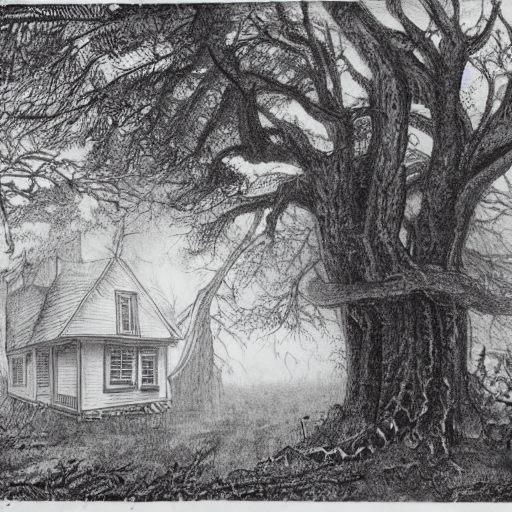

In [ ]:
# Now we can write a prompt to generate images with Stable Diffusion.
# The images are in the PIL image format.
prompt = """
  The house stood in a dark, misty, mysterious, spooky forest. 
  It stands coiled between trees 
  and it had minor fragments of glass shattered on ground.
  """

# Using `autocast` will run inference faster because it uses half-precision.
from torch import autocast
with autocast("cuda"):
  image = pipe(prompt).images[0]
display(image)

  0%|          | 0/51 [00:00<?, ?it/s]

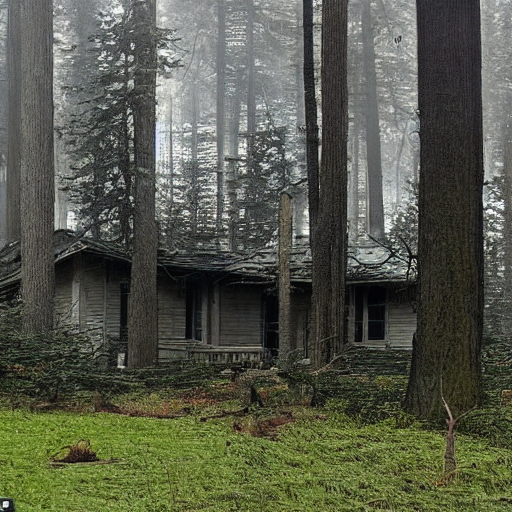

In [ ]:
# Running the above cell multiple times will give you a different image every time. 
# If you want deterministic output you can pass a random seed to the pipeline. 
# Every time you use the same seed you'll have the same image result.
generator = torch.Generator("cuda").manual_seed(1234)
with autocast("cuda"):
  image = pipe(prompt, generator = generator).images[0]
image

  0%|          | 0/501 [00:00<?, ?it/s]

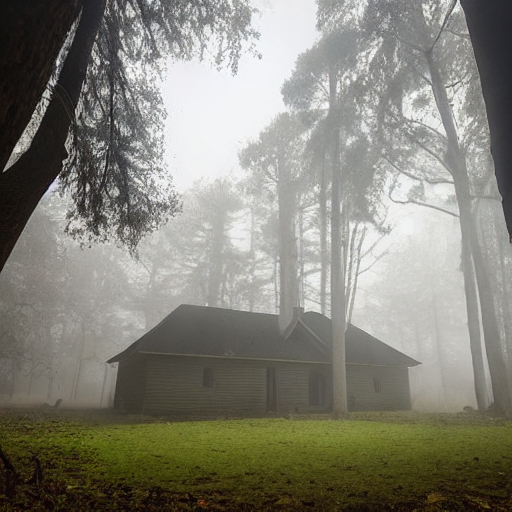

In [ ]:
# You can change the number of inference steps using the `num_inference_steps` argument. 
# In general, results are better the more steps you use.
image = pipe(prompt, num_inference_steps = 500).images[0]
image

In [ ]:
# We can create many images in one go by supplying a list of descriptions
num_images = 4
prompt = ["a pink pig is jumping to the rainbow"] * num_images
with autocast("cuda"):
  images = pipe(prompt).images
images

  0%|          | 0/51 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F422A6AD9D0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F422A6ADF50>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F422A6ADD50>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F422A6ADD90>]

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define a function to rotate an PIL image (optionally) and convert it to a numpy array
def preprocess_img(img):
  #img = img.rotate(180)
  img = np.asarray(img)
  return img

In [ ]:
# Append the preprocessed images in a list
img_arr = []
for image in images:
  img_arr.append(preprocess_img(image))
img_arr[0].shape

(512, 512, 3)

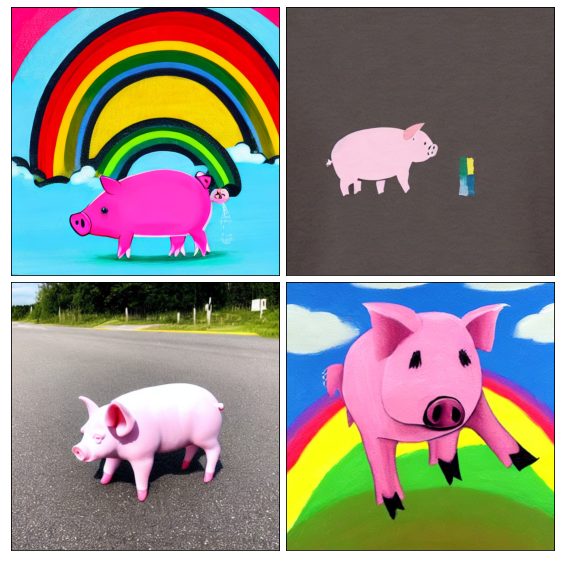

In [ ]:
# Define figure size
fig = plt.figure(figsize = (10., 10.))

# Make a 2 x 2 grid of axes
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(
  fig, 111, 
  # Create 2 x 2 grid of axes
  nrows_ncols = (2, 2),
  # Pad between axes
  axes_pad = 0.1)

# Show the images in the grid without x and y ticks
for ax, im in zip(grid, img_arr):
  ax.imshow(im)
  ax.set_xticks([])
  ax.set_yticks([])

  0%|          | 0/51 [00:00<?, ?it/s]

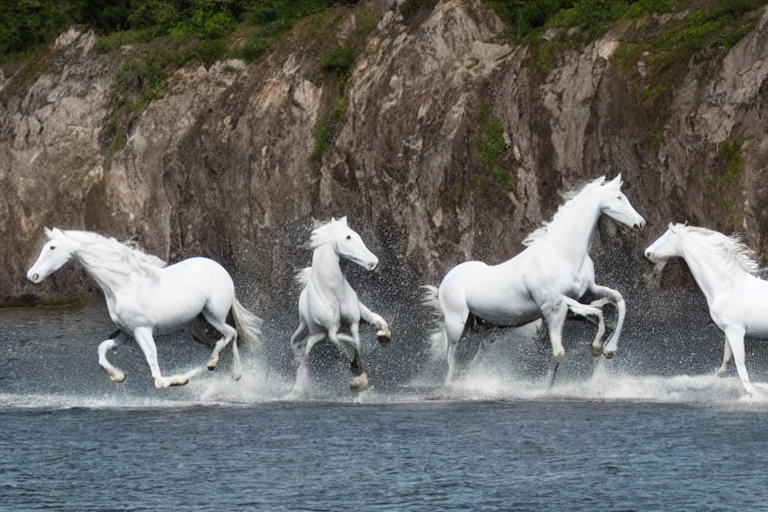

In [ ]:
# You can also create non-square images
prompt = "Three white horses with shiny wings are flying above a river."
with autocast("cuda"):
  image = pipe(prompt, height = 512, width = 768).images[0]
image